# Neural Network from scratch: Embedding + BiLSTM (RNN)

Cel:
- zbudować własny model NN bez transformerów
- porównać wyniki z TF-IDF baseline
- ewaluacja: precision/recall/F1 + confusion matrix

In [98]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

RANDOM_STATE = 42
tf.__version__

'2.20.0'

In [99]:
REPO_ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
data_path = REPO_ROOT / "data" / "processed" / "sms_spam_clean.csv"
assert data_path.exists(), f"Brak pliku: {data_path}"

In [100]:
df = pd.read_csv(data_path)
X = df["text_clean"].astype(str).values
y = df["label_bin"].astype(int).values

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

# dodatkowo wydzielam zbiór walidacyjny
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y_train
)

print(len(X_train), len(X_val), len(X_test))
print("spam% train/val/test:", y_train.mean().round(4), y_val.mean().round(4), y_test.mean().round(4))

3565 892 1115
spam% train/val/test: 0.1341 0.1345 0.1336


In [101]:
VOCAB_SIZE = 20000 # optymalne hiperparametry po wykonaniu ewaluacji dla 10000, 20000, 30000
SEQ_LEN = 80 # optymalne hiperparametry po wykonaniu ewaluacji dla 60, 80, 100, 120

vectorizer = layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=SEQ_LEN,
    standardize=None  #pracujemy na przeprocesowanych danych
)

vectorizer.adapt(X_train)

example = X_train[0]
print("Example:", example)
print("Vectorized:", vectorizer(np.array([example])).numpy()[0][:20])

Example: that sucks. so what do you got planned for your yo valentine? i am your yo valentine aren't i?
Vectorized: [  20 1463   23   49   33    4   48 2003   12   13  456 4473    3   54
   13  456 1192 1365 7288    0]


In [102]:
BATCH_SIZE = 64

def make_ds(X, y, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(X), seed=RANDOM_STATE)
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_ds(X_train, y_train, shuffle=True)
val_ds = make_ds(X_val, y_val, shuffle=False)
test_ds = make_ds(X_test, y_test, shuffle=False)

In [103]:
EMB_DIM = 128

inputs = keras.Input(shape=(1,), dtype=tf.string)
x = vectorizer(inputs)
x = layers.Embedding(VOCAB_SIZE, EMB_DIM)(x)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=False))(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, outputs)
model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_10           │ (None, 80)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_10 (Embedding)        │ (None, 80, 128)        │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_10                │ (None, 128)            │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,667,137 (10.17 MB)

 Trainable params: 2,667,137 (10.17 MB)

 Non-trainable params: 0 (0.00 B)

In [104]:
# class weights: 0=ham, 1=spam
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
total = neg + pos
class_weight = {
    0: total / (2 * neg),
    1: total / (2 * pos)
}
class_weight

{0: np.float64(0.5774214447683835), 1: np.float64(3.7290794979079496)}

In [105]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=[
        keras.metrics.BinaryAccuracy(name="acc"),
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall"),
    ]
)

callbacks = [keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    class_weight=class_weight,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - acc: 0.8735 - loss: 0.4077 - precision: 0.5222 - recall: 0.6653 - val_acc: 0.9664 - val_loss: 0.1063 - val_precision: 0.8750 - val_recall: 0.8750
Epoch 2/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - acc: 0.9728 - loss: 0.1090 - precision: 0.8601 - recall: 0.9519 - val_acc: 0.9765 - val_loss: 0.0757 - val_precision: 0.9541 - val_recall: 0.8667
Epoch 3/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - acc: 0.9958 - loss: 0.0328 - precision: 0.9813 - recall: 0.9874 - val_acc: 0.9765 - val_loss: 0.0965 - val_precision: 0.9091 - val_recall: 0.9167
Epoch 4/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - acc: 0.9980 - loss: 0.0131 - precision: 0.9916 - recall: 0.9937 - val_acc: 0.9776 - val_loss: 0.0935 - val_precision: 0.9032 - val_recall: 0.9333
Epoch 5/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - acc: 0.9994 - loss: 0.0052 - precision: 0.9979 - recall: 0.9979 - val_acc: 0.9787 - val_loss: 0.0959 - val_precision: 0.9174 - val_recall: 0.9250


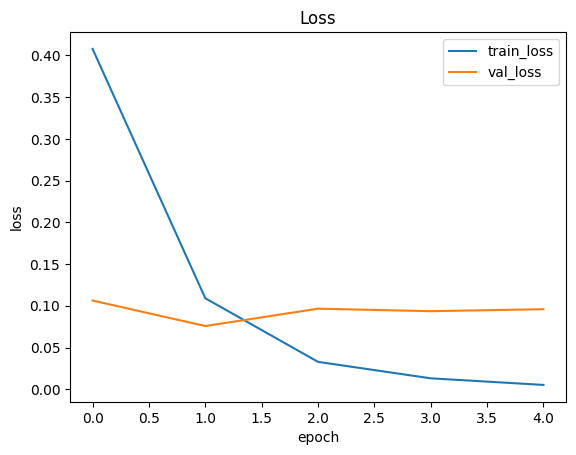

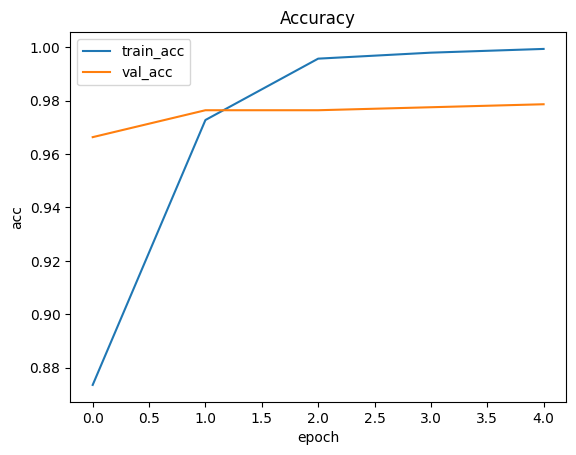

In [106]:
hist = pd.DataFrame(history.history)

plt.figure()
plt.plot(hist["loss"], label="train_loss")
plt.plot(hist["val_loss"], label="val_loss")
plt.title("Loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

plt.figure()
plt.plot(hist["acc"], label="train_acc")
plt.plot(hist["val_acc"], label="val_acc")
plt.title("Accuracy")
plt.xlabel("epoch")
plt.ylabel("acc")
plt.legend()
plt.show()

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Accuracy: 0.9829596412556054
Precision(spam): 0.9642857142857143
Recall(spam): 0.9060402684563759
F1(spam): 0.9342560553633218
Macro F1: 0.9622336433436908

Classification report:

              precision    recall  f1-score   support

      ham(0)       0.99      0.99      0.99       966
     spam(1)       0.96      0.91      0.93       149

    accuracy                           0.98      1115
   macro avg       0.97      0.95      0.96      1115
weighted avg       0.98      0.98      0.98      1115



<Figure size 640x480 with 0 Axes>

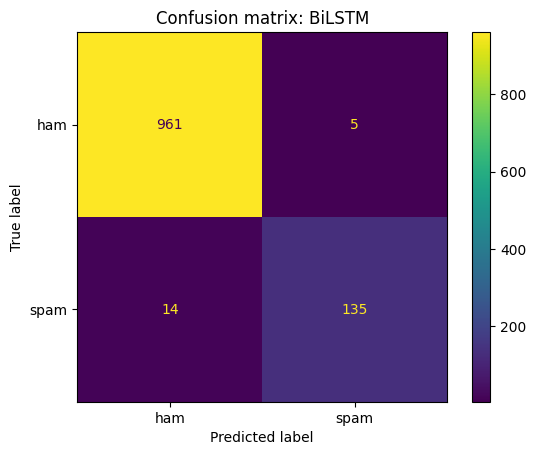

In [107]:
# predykcje (probabilities -> class)
y_prob = model.predict(test_ds).ravel()
y_pred = (y_prob >= 0.5).astype(int)

acc = accuracy_score(y_test, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="binary", zero_division=0)
macro_f1 = precision_recall_fscore_support(y_test, y_pred, average="macro", zero_division=0)[2]

print("Accuracy:", acc)
print("Precision(spam):", prec)
print("Recall(spam):", rec)
print("F1(spam):", f1)
print("Macro F1:", macro_f1)

print("\nClassification report:\n")
print(classification_report(y_test, y_pred, target_names=["ham(0)", "spam(1)"], zero_division=0))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["ham", "spam"])
plt.figure()
disp.plot(values_format="d")
plt.title("Confusion matrix: BiLSTM")
plt.show()

In [108]:
out_dir = REPO_ROOT / "reports"
out_dir.mkdir(parents=True, exist_ok=True)

res = pd.DataFrame([{
    "model": "BiLSTM (Embedding)",
    "accuracy": acc,
    "precision_spam": prec,
    "recall_spam": rec,
    "f1_spam": f1,
    "macro_f1": macro_f1
}])

out_path = out_dir / "nn_results.csv"
res.to_csv(out_path, index=False)
out_path

PosixPath('/Users/konrad/Documents/-ZUM_2025_KonradObrebski/reports/nn_results.csv')